In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


import math
#from pandas_datareader import data as pdr
from datetime import datetime,date
import yfinance as yf
#yf.pdr_override()
import joblib
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
def generate_features(df):

    df['Diff'] = df['Close'].pct_change()
    # df['Diff_Vol'] = df['Volume'].pct_change()
    df['EMA_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['EMA_21'] = df['Close'].ewm(span=21, adjust=False).mean()

    df['MA_7_volume'] = df['Volume'].rolling(window=7).mean()
    df['MA_14_volume'] = df['Volume'].rolling(window=14).mean()
    df['MA_21_volume'] = df['Volume'].rolling(window=21).mean()

    # Calculate new features
    df['Daily_Close'] = (df['Close'] - df['Close']).shift(1) / df['Close'].shift(1)
    df['Daily_Volume'] = (df['Volume'] - df['Volume']).shift(1) / df['Volume'].shift(1)

    df['Close_to_Open'] = (df['Close'] - df['Open']) / df['Close']
    df['Close_to_High'] = (df['Close'] - df['High']) / df['Close']
    df['Close_to_Low'] = (df['Close'] - df['Low']) / df['Close']

    df['Volume_Change_7'] = (df['Volume'] - df['MA_7_volume']) / df['MA_21_volume']
    df['Volume_Change_14'] = (df['Volume'] - df['MA_14_volume']) / df['MA_21_volume']
    df['Volume_Change_21'] = (df['Volume'] - df['MA_21_volume']) / df['MA_21_volume']
    df['EMA_7_Change'] = (df['Close'] - df['EMA_7']) / df['Close']
    df['EMA_14_Change'] = (df['Close'] - df['EMA_14']) / df['Close']
    df['EMA_21_Change'] = (df['Close'] - df['EMA_21']) / df['Close']

    # Calculate target variable
    df['Target'] = np.where(df['Close'].shift(-10) > df['Close'] * 1.05, 1, 0)
    df['Target_Close'] = df['Close'].shift(-10)

     # Select relevant features
    features = ['Open','High','Low' ,'Close', 'Volume', 'Diff',
              'EMA_7', 'EMA_14', 'EMA_21', 'MA_7_volume','MA_14_volume' ,'MA_21_volume',
              'Daily_Close', 'Daily_Volume', 'Close_to_Open', 'Close_to_High', 'Close_to_Low',
    'Volume_Change_7', 'Volume_Change_14', 'Volume_Change_21',
    'EMA_7_Change', 'EMA_14_Change', 'EMA_21_Change']

  # Add last close price and volume of the last 21 days
    for i in range(1, 22):

      df[f'Open_{i}'] = df['Open'].shift(i)
      df[f'High_{i}'] = df['High'].shift(i)
      df[f'Low_{i}'] = df['Low'].shift(i)
      df[f'Close_{i}'] = df['Close'].shift(i)
      df[f'Volume_{i}'] = df['Volume'].shift(i)
      df[f'Diff_{i}'] = df['Diff'].shift(i)
      #df[f'Diff_Vol_{i}'] = df['Diff_Vol'].shift(i)

      df[f'EMA_7_{i}'] = df['EMA_7'].shift(i)
      df[f'EMA_14_{i}'] = df['EMA_14'].shift(i)
      df[f'EMA_21_{i}'] = df['EMA_21'].shift(i)
      df[f'MA_7_volume_{i}'] = df['MA_7_volume'].shift(i)
      df[f'MA_14_volume_{i}'] = df['MA_14_volume'].shift(i)
      df[f'MA_21_volume_{i}'] = df['MA_21_volume'].shift(i)

      df[f'Daily_Close_{i}'] = df['Daily_Close'].shift(i)
      df[f'Daily_Volume_{i}'] = df['Daily_Volume'].shift(i)
      df[f'Close_to_Open_{i}'] = df['Close_to_Open'].shift(i)
      df[f'Close_to_High_{i}'] = df['Close_to_High'].shift(i)
      df[f'Close_to_Low_{i}'] = df['Close_to_Low'].shift(i)
      df[f'Volume_Change_7_{i}'] = df['Volume_Change_7'].shift(i)
      df[f'Volume_Change_14_{i}'] = df['Volume_Change_14'].shift(i)
      df[f'Volume_Change_21_{i}'] = df['Volume_Change_21'].shift(i)
      df[f'EMA_7_Change_{i}'] = df['EMA_7_Change'].shift(i)
      df[f'EMA_14_Change_{i}'] = df['EMA_14_Change'].shift(i)
      df[f'EMA_21_Change_{i}'] = df['EMA_21_Change'].shift(i)


      features.extend([f'Open_{i}',f'High_{i}',f'Low_{i}',f'Close_{i}', f'Volume_{i}',f'Diff_{i}',
                       #f'EMA_7_{i}',f'EMA_14_{i}',f'EMA_21_{i}',
                       # f'MA_7_volume_{i}',f'MA_14_volume_{i}',f'MA_21_volume_{i}',
                     # f'Daily_Close_{i}', f'Daily_Volume_{i}',
                      f'Close_to_Open_{i}',f'Close_to_High_{i}',f'Close_to_Low_{i}',
                      #f'Volume_Change_7_{i}',
                      # f'Volume_Change_14_{i}',f'Volume_Change_21_{i}',
                       #f'EMA_7_Change_{i}',
                       #f'EMA_14_Change_{i}',
                       #f'EMA_21_Change_{i}'
                       ])
    return df,features

In [18]:
def logistic_prediction_val(symbol,plot_confusion=False,save_model=True):

  df = yf.download(symbol + '.NS',"2018-01-01", "2024-09-15")

  df_features, features = generate_features(df)

  X = df[features].dropna()

  # Select the target variable
  y = df['Target']
  y_close = df['Target_Close']
  # Calculate number of validation days
  validation_days = 21

  # Separate validation data
  X_val = X[-validation_days:]
  y_val = y[-validation_days:]
  y_close_val = y_close[-validation_days:]
  merged_df = pd.concat([X_val[['Close']], y_val], axis=1)
  merged_df.columns = ['Close', 'Target']
  merged_df['Target_Close'] = y_close
  merged_df['Symbol'] = symbol
  merged_df =  merged_df[['Symbol','Close', 'Target_Close','Target']]

  # Remove validation data from X and y
  X = X[:-validation_days]
  y = y[:-validation_days].dropna()
  # Ensure that y corresponds to the same samples as X
  y = y.head(len(X))



  train_until= dt.datetime(year=2024, month=1, day=1)
  # Split the data based on train_until
  train_mask = X.index <= train_until
  X_train = X[train_mask]
  y_train = y[train_mask].dropna()
  X_test = X[~train_mask]
  y_test = y[~train_mask].dropna()

    # Ensure that y corresponds to the same samples as X
  y_train = y_train.head(len(X_train))
  y_test = y_test.head(len(X_test))
  # Split the data into training and testing sets
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()

  scaled_X_train = scaler.fit_transform(X_train)
  scaled_X_test = scaler.transform(X_test)
  scaled_X_val = scaler.transform(X_val)

  # Initialize the logistic regression model
  model = LogisticRegression(class_weight='balanced')
  #model = RandomForestClassifier( n_estimators=100,  max_depth=3, random_state=42, class_weight='balanced',)

  # Train the model
  model.fit(scaled_X_train, y_train)

  # Make predictions on the test set
  y_train_pred = model.predict(scaled_X_train)
  y_test_pred = model.predict(scaled_X_test)


  # Evaluate the model
  accuracy = accuracy_score(y_test, y_test_pred)
  #print(f'Accuracy: {accuracy}')
  #print(confusion_matrix(y_test,predictions))
  #print(classification_report(y_test, predictions))


  # Assuming y_test and predictions are available
  precision = precision_score(y_test, y_test_pred)
  recall = recall_score(y_test, y_test_pred)
  f1 = f1_score(y_test, y_test_pred)
  roc_auc = roc_auc_score(y_test, y_test_pred)
  if plot_confusion:
    plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
    plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

  validations = model.predict(scaled_X_val)
  merged_df['Predictions'] = validations
  # Reset the index and drop the old 'Date' column if it exists
  merged_df = merged_df.reset_index(drop=False)

  if save_model:
    import os
    os.makedirs("models", exist_ok=True)  # Create the "models" folder if it doesn't exist
    joblib.dump(model, os.path.join("models", f"{symbol}_model.h5"))


  return symbol,round(accuracy,2),round(precision,2),round(recall,2),round(roc_auc,2),merged_df


[*********************100%%**********************]  1 of 1 completed


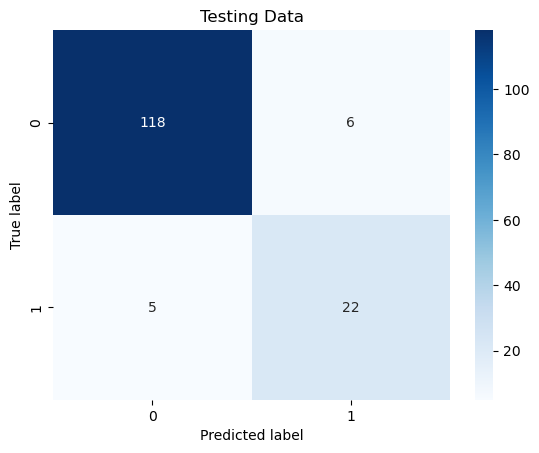

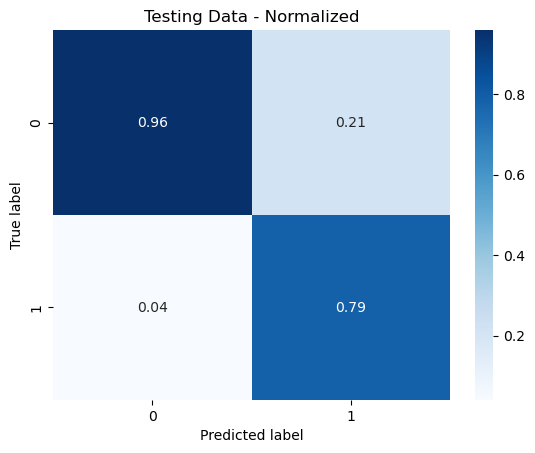

('TCS', 0.93, 0.79, 0.81, 0.88)
         Date Symbol        Close  Target_Close  Target  Predictions
0  2024-08-16    TCS  4416.049805   4553.750000       0            0
1  2024-08-19    TCS  4490.000000   4521.049805       0            0
2  2024-08-20    TCS  4523.299805   4512.350098       0            0
3  2024-08-21    TCS  4551.500000   4479.250000       0            0
4  2024-08-22    TCS  4502.000000   4475.950195       0            0
5  2024-08-23    TCS  4463.899902   4456.750000       0            0
6  2024-08-26    TCS  4502.450195   4449.549805       0            0
7  2024-08-27    TCS  4497.149902   4507.850098       0            0
8  2024-08-28    TCS  4506.049805   4479.350098       0            0
9  2024-08-29    TCS  4511.799805   4517.700195       0            0
10 2024-08-30    TCS  4553.750000   4522.600098       0            0
11 2024-09-02    TCS  4521.049805           NaN       0            0
12 2024-09-03    TCS  4512.350098           NaN       0            0
13

In [20]:
ms = logistic_prediction_val('TCS',plot_confusion=True)

print_msg = []
df_result = pd.DataFrame()
msg =ms[0:5]
df_pred = ms[5]
print_msg.append(msg)
print(msg)
print(df_pred)

In [21]:
df_stocks = pd.read_csv('MarketCap.csv')
print_msg = []
df_result = pd.DataFrame()

stock_symbols = df_stocks['symbol']
for i in stock_symbols:
  try:
    ms = logistic_prediction_val(i)
    msg =ms[0:5]
    df_pred = ms[5]
    print_msg.append(msg)
    print(msg)
    df_result= pd.concat([df_result,df_pred],ignore_index=True)

  except :
    print(i)

[*********************100%%**********************]  1 of 1 completed
('RELIANCE', 0.94, 0.72, 1.0, 0.96)
[*********************100%%**********************]  1 of 1 completed
('TCS', 0.93, 0.79, 0.81, 0.88)
[*********************100%%**********************]  1 of 1 completed
('HDFCBANK', 0.95, 0.77, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('ICICIBANK', 0.97, 0.81, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('INFY', 0.95, 0.85, 1.0, 0.97)
[*********************100%%**********************]  1 of 1 completed
('SBIN', 0.96, 0.86, 1.0, 0.97)
[*********************100%%**********************]  1 of 1 completed
('BHARTIARTL', 0.91, 0.77, 0.98, 0.93)
[*********************100%%**********************]  1 of 1 completed
('LICI', 0.83, 0.78, 0.82, 0.83)
[*********************100%%**********************]  1 of 1 completed
('HINDUNILVR', 0.95, 0.79, 1.0, 0.97)
[*********************100%%**********************]  1 of 1 comp

[*********************100%%**********************]  1 of 1 completed
('BAJAJHLDNG', 0.95, 0.78, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('IDBI', 0.96, 0.88, 1.0, 0.97)
[*********************100%%**********************]  1 of 1 completed
('DABUR', 0.94, 0.86, 0.76, 0.87)
[*********************100%%**********************]  1 of 1 completed
('HEROMOTOCO', 0.97, 0.96, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('APOLLOHOSP', 0.95, 0.9, 0.88, 0.92)
[*********************100%%**********************]  1 of 1 completed
('SHREECEM', 0.97, 0.95, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 completed
('ABB', 0.97, 1.0, 0.9, 0.95)
[*********************100%%**********************]  1 of 1 completed
('CHOLAFIN', 0.97, 0.91, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('NHPC', 0.87, 0.84, 0.83, 0.87)
[*********************100%%**********************]  1 of 1 co


1 Failed download:
['MCDOWELL-N.NS']: Exception('%ticker%: No data found, symbol may be delisted')



MCDOWELL-N
[*********************100%%**********************]  1 of 1 completed
('BOSCHLTD', 0.96, 0.92, 0.92, 0.95)
[*********************100%%**********************]  1 of 1 completed
('HINDPETRO', 0.88, 0.77, 1.0, 0.9)
[*********************100%%**********************]  1 of 1 completed
('ICICIGI', 0.92, 0.75, 1.0, 0.95)
[*********************100%%**********************]  1 of 1 completed
('HDFCAMC', 0.94, 0.83, 0.98, 0.95)
[*********************100%%**********************]  1 of 1 completed
('JSWENERGY', 0.93, 0.86, 0.94, 0.93)
[*********************100%%**********************]  1 of 1 completed
('BHEL', 0.91, 0.84, 0.99, 0.91)
[*********************100%%**********************]  1 of 1 completed
('JINDALSTEL', 0.97, 0.97, 0.93, 0.96)
[*********************100%%**********************]  1 of 1 completed
('IDEA', 0.92, 0.83, 1.0, 0.94)
[*********************100%%**********************]  1 of 1 completed
('MOTHERSON', 0.85, 0.85, 0.87, 0.85)
[*********************100%%****************

[*********************100%%**********************]  1 of 1 completed
('MRPL', 0.87, 0.84, 0.84, 0.86)
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['L&TFH.NS']: Exception('%ticker%: No data found, symbol may be delisted')



L&TFH
[*********************100%%**********************]  1 of 1 completed
('POLICYBZR', 0.65, 0.55, 0.97, 0.7)
[*********************100%%**********************]  1 of 1 completed
('SUNDARMFIN', 0.88, 0.79, 0.88, 0.88)
[*********************100%%**********************]  1 of 1 completed
('PETRONET', 0.89, 0.81, 0.97, 0.91)
[*********************100%%**********************]  1 of 1 completed
('THERMAX', 0.96, 0.99, 0.93, 0.96)
[*********************100%%**********************]  1 of 1 completed
('COFORGE', 0.95, 1.0, 0.85, 0.92)
[*********************100%%**********************]  1 of 1 completed
('HUDCO', 0.95, 0.94, 0.98, 0.94)
[*********************100%%**********************]  1 of 1 completed
('NIACL', 0.91, 0.8, 0.93, 0.92)
[*********************100%%**********************]  1 of 1 completed
('PAGEIND', 0.93, 0.63, 1.0, 0.96)
[*********************100%%**********************]  1 of 1 completed
('KALYANKJIL', 0.92, 0.9, 0.9, 0.92)
[*********************100%%**********************

[*********************100%%**********************]  1 of 1 completed
('AARTIIND', 0.95, 0.88, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('KANSAINER', 0.95, 0.58, 0.78, 0.87)
[*********************100%%**********************]  1 of 1 completed
('NBCC', 0.96, 0.95, 0.97, 0.96)
[*********************100%%**********************]  1 of 1 completed
('TATACHEM', 0.99, 0.97, 1.0, 1.0)
[*********************100%%**********************]  1 of 1 completed
('APARINDS', 0.93, 0.85, 0.96, 0.94)
[*********************100%%**********************]  1 of 1 completed
('SUNTV', 0.94, 0.79, 1.0, 0.96)
[*********************100%%**********************]  1 of 1 completed
('GRINDWELL', 0.8, 0.66, 0.82, 0.81)
[*********************100%%**********************]  1 of 1 completed
('JBMA', 0.96, 0.97, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('ASTERDM', 0.94, 0.83, 0.91, 0.93)
[*********************100%%**********************]  1 of 1 c

[*********************100%%**********************]  1 of 1 completed
('AFFLE', 0.94, 0.87, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('OLECTRA', 0.91, 0.83, 0.93, 0.91)
[*********************100%%**********************]  1 of 1 completed
('JINDALSAW', 0.97, 0.92, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('INDIAMART', 0.83, 0.61, 0.71, 0.79)
[*********************100%%**********************]  1 of 1 completed
('CENTURYTEX', 0.96, 0.94, 0.97, 0.96)
[*********************100%%**********************]  1 of 1 completed
('NATCOPHARM', 0.94, 0.88, 0.94, 0.94)
[*********************100%%**********************]  1 of 1 completed
('HSCL', 0.93, 0.88, 0.92, 0.93)
[*********************100%%**********************]  1 of 1 completed
('J&KBANK', 0.93, 0.77, 0.86, 0.9)
[*********************100%%**********************]  1 of 1 completed
('MANAPPURAM', 0.95, 0.88, 0.98, 0.96)
[*********************100%%*********************


1 Failed download:
['AEGISCHEM.NS']: Exception('%ticker%: No data found, symbol may be delisted')



AEGISCHEM
[*********************100%%**********************]  1 of 1 completed
('KARURVYSYA', 0.95, 0.92, 0.88, 0.93)
[*********************100%%**********************]  1 of 1 completed
('BLS', 0.91, 0.81, 1.0, 0.93)
[*********************100%%**********************]  1 of 1 completed
('ANANDRATHI', 0.83, 0.76, 0.79, 0.82)
[*********************100%%**********************]  1 of 1 completed
('MGL', 0.97, 0.94, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('WELSPUNLIV', 0.86, 0.7, 0.85, 0.86)
[*********************100%%**********************]  1 of 1 completed
('NUVAMA', 0.7, 0.5, 0.49, 0.64)
[*********************100%%**********************]  1 of 1 completed
('CLEAN', 0.89, 0.66, 0.76, 0.84)
[*********************100%%**********************]  1 of 1 completed
('ARE&M', 0.44, 0.44, 1.0, 0.5)
[*********************100%%**********************]  1 of 1 completed
('WELCORP', 0.95, 0.87, 0.98, 0.96)
[*********************100%%**********************]  1 

[*********************100%%**********************]  1 of 1 completed
('ELECON', 0.94, 0.85, 1.0, 0.95)
[*********************100%%**********************]  1 of 1 completed
('AETHER', 0.94, 0.85, 0.82, 0.89)
[*********************100%%**********************]  1 of 1 completed
('RAYMOND', 0.95, 0.91, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('SPARC', 0.98, 0.98, 0.95, 0.97)
[*********************100%%**********************]  1 of 1 completed
('CEATLTD', 0.83, 0.81, 0.57, 0.76)
[*********************100%%**********************]  1 of 1 completed
('ECLERX', 0.99, 0.93, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('COCHINSHIP', 0.91, 0.89, 0.97, 0.9)
[*********************100%%**********************]  1 of 1 completed
('AAVAS', 0.92, 0.8, 0.8, 0.88)
[*********************100%%**********************]  1 of 1 completed
('ALKYLAMINE', 0.94, 0.86, 0.89, 0.92)
[*********************100%%**********************]  1 of 1 co

[*********************100%%**********************]  1 of 1 completed
('ESABINDIA', 0.97, 0.9, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('HOMEFIRST', 0.93, 0.82, 0.84, 0.9)
[*********************100%%**********************]  1 of 1 completed
('JLHL', 0.41, 0.31, 1.0, 0.6)
[*********************100%%**********************]  1 of 1 completed
('MHRIL', 0.98, 1.0, 0.91, 0.96)
[*********************100%%**********************]  1 of 1 completed
('RESPONIND', 0.97, 0.88, 0.96, 0.97)
[*********************100%%**********************]  1 of 1 completed
('MANINFRA', 0.96, 0.89, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('TVSSCS', 0.81, 0.0, 0.0, 0.5)
[*********************100%%**********************]  1 of 1 completed
('SHOPERSTOP', 0.98, 0.96, 0.93, 0.96)
[*********************100%%**********************]  1 of 1 completed
('NETWEB', 0.51, 0.51, 1.0, 0.5)
[*********************100%%**********************]  1 of 1 comp


1 Failed download:
['UJJIVAN.NS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2024-09-15)')



UJJIVAN
[*********************100%%**********************]  1 of 1 completed
('SHAREINDIA', 0.87, 0.45, 0.53, 0.72)
[*********************100%%**********************]  1 of 1 completed
('SUNTECK', 0.97, 0.92, 0.98, 0.97)
[*********************100%%**********************]  1 of 1 completed
('TCI', 0.94, 0.74, 0.96, 0.95)
[*********************100%%**********************]  1 of 1 completed
('AHLUCONT', 0.32, 0.08, 0.17, 0.27)
[*********************100%%**********************]  1 of 1 completed
('MSTCLTD', 0.95, 0.95, 0.94, 0.95)
[*********************100%%**********************]  1 of 1 completed
('GREENLAM', 0.99, 0.93, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('PRINCEPIPE', 0.96, 0.9, 0.9, 0.94)
[*********************100%%**********************]  1 of 1 completed
('HCC', 0.95, 0.91, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('DBL', 0.98, 0.96, 0.98, 0.98)
[*********************100%%**********************]  1

[*********************100%%**********************]  1 of 1 completed
('SUPRAJIT', 0.95, 0.9, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('DBCORP', 0.99, 0.97, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('TEAMLEASE', 0.99, 0.98, 0.98, 0.98)
[*********************100%%**********************]  1 of 1 completed
('AURIONPRO', 0.96, 0.97, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('NFL', 0.95, 0.95, 0.95, 0.95)
[*********************100%%**********************]  1 of 1 completed
('VRLLOG', 0.93, 0.61, 0.93, 0.93)
[*********************100%%**********************]  1 of 1 completed
('KESORAMIND', 0.95, 0.86, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('GALLANTT', 0.89, 0.81, 0.99, 0.9)
[*********************100%%**********************]  1 of 1 completed
('GABRIEL', 0.97, 0.95, 0.92, 0.95)
[*********************100%%**********************]  1 o

[*********************100%%**********************]  1 of 1 completed
('VMART', 0.93, 0.85, 1.0, 0.94)
[*********************100%%**********************]  1 of 1 completed
('LAOPALA', 0.99, 1.0, 0.95, 0.97)
[*********************100%%**********************]  1 of 1 completed
('SUNFLAG', 0.97, 0.9, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('KSCL', 0.97, 0.96, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('UNICHEMLAB', 0.97, 0.94, 0.94, 0.96)
[*********************100%%**********************]  1 of 1 completed
('HMAAGRO', 0.87, 0.81, 0.58, 0.77)
[*********************100%%**********************]  1 of 1 completed
('JTEKTINDIA', 0.95, 0.96, 0.91, 0.94)
[*********************100%%**********************]  1 of 1 completed
('IMAGICAA', 0.63, 0.48, 0.9, 0.69)
[*********************100%%**********************]  1 of 1 completed
('DELTACORP', 0.96, 0.9, 0.95, 0.96)
[*********************100%%**********************]  1 of 

[*********************100%%**********************]  1 of 1 completed
SUNCLAY
[*********************100%%**********************]  1 of 1 completed
('AXISCADES', 0.97, 0.94, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('JCHAC', 0.69, 0.57, 0.64, 0.68)
[*********************100%%**********************]  1 of 1 completed
('IDEAFORGE', 0.83, 0.43, 0.12, 0.55)
[*********************100%%**********************]  1 of 1 completed
('SUPRIYA', 0.89, 0.83, 0.85, 0.88)
[*********************100%%**********************]  1 of 1 completed
('NILKAMAL', 0.99, 0.89, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('GIPCL', 0.91, 0.91, 0.84, 0.89)
[*********************100%%**********************]  1 of 1 completed
('MOLDTKPAC', 0.99, 0.95, 1.0, 1.0)
[*********************100%%**********************]  1 of 1 completed
('FILATEX', 0.97, 0.95, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('HERITGFOOD', 


1 Failed download:
['ISMTLTD.NS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2024-09-15)')



ISMTLTD
[*********************100%%**********************]  1 of 1 completed
('SWARAJENG', 0.97, 0.97, 0.91, 0.95)
[*********************100%%**********************]  1 of 1 completed
('TATVA', 0.93, 0.77, 0.77, 0.87)
[*********************100%%**********************]  1 of 1 completed
('PARACABLES', 0.96, 0.92, 0.98, 0.96)
[*********************100%%**********************]  1 of 1 completed
('MAHLOG', 0.98, 0.96, 0.98, 0.98)
[*********************100%%**********************]  1 of 1 completed
('KCP', 0.94, 0.88, 1.0, 0.95)
[*********************100%%**********************]  1 of 1 completed
('PARAS', 0.82, 0.67, 0.94, 0.85)
[*********************100%%**********************]  1 of 1 completed
('GTLINFRA', 0.95, 0.98, 0.9, 0.94)
[*********************100%%**********************]  1 of 1 completed
('SOTL', 0.95, 0.96, 0.93, 0.95)
[*********************100%%**********************]  1 of 1 completed
('DIAMONDYD', 0.97, 0.94, 0.94, 0.96)
[*********************100%%**********************]  


1 Failed download:
['TCNSBRANDS.NS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2024-09-15)')



TCNSBRANDS
[*********************100%%**********************]  1 of 1 completed
('EVEREADY', 0.96, 0.85, 0.92, 0.94)
[*********************100%%**********************]  1 of 1 completed
('BEPL', 0.99, 0.97, 1.0, 0.99)
[*********************100%%**********************]  1 of 1 completed
('DHANI', 0.85, 0.78, 0.82, 0.84)
[*********************100%%**********************]  1 of 1 completed
('ALEMBICLTD', 0.95, 0.9, 0.98, 0.95)
[*********************100%%**********************]  1 of 1 completed
('MANINDS', 0.98, 1.0, 0.95, 0.98)
[*********************100%%**********************]  1 of 1 completed
('BARBEQUE', 0.91, 0.64, 0.8, 0.87)
[*********************100%%**********************]  1 of 1 completed
('PCJEWELLER', 0.99, 0.98, 0.98, 0.99)
[*********************100%%**********************]  1 of 1 completed
('DIVGIITTS', 0.9, 0.5, 0.4, 0.68)
[*********************100%%**********************]  1 of 1 completed
GANDHAR
[*********************100%%**********************]  1 of 1 completed
('IN

[*********************100%%**********************]  1 of 1 completed
('GVKPIL', 0.71, 0.26, 0.23, 0.53)
[*********************100%%**********************]  1 of 1 completed
('JINDRILL', 0.97, 0.87, 1.0, 0.98)
[*********************100%%**********************]  1 of 1 completed
('JASH', 0.49, 0.41, 0.74, 0.54)
[*********************100%%**********************]  1 of 1 completed
('CENTUM', 0.95, 0.89, 0.93, 0.94)
[*********************100%%**********************]  1 of 1 completed
('RPSGVENT', 0.81, 0.6, 0.79, 0.81)
[*********************100%%**********************]  1 of 1 completed
('FMGOETZE', 0.97, 0.9, 0.97, 0.97)
[*********************100%%**********************]  1 of 1 completed
('RAMASTEEL', 0.93, 0.9, 0.79, 0.88)
[*********************100%%**********************]  1 of 1 completed
('RAMCOIND', 0.92, 0.79, 0.98, 0.94)
[*********************100%%**********************]  1 of 1 completed
('SDBL', 0.93, 0.79, 0.91, 0.92)
[*********************100%%**********************]  1 of 1 co

In [24]:
df_result.to_csv('model_result.csv')
df_result

,Date,Symbol,Close,Target_Close,Target,Predictions
0,2024-08-16,RELIANCE,2956.399902,3019.250000,0,0
1,2024-08-19,RELIANCE,2976.800049,3032.500000,0,0
2,2024-08-20,RELIANCE,2991.899902,3018.250000,0,0
3,2024-08-21,RELIANCE,2997.350098,3029.100098,0,0
4,2024-08-22,RELIANCE,2996.250000,2985.949951,0,0
...,...,...,...,...,...,...
19819,2024-09-09,BFINVEST,587.150024,NaN,0,0
19820,2024-09-10,BFINVEST,604.099976,NaN,0,0
19821,2024-09-11,BFINVEST,601.150024,NaN,0,0
19822,2024-09-12,BFINVEST,610.849976,NaN,0,0


In [23]:
columns = ['Symbol','Accuracy','Precision','Recall','ROC Score']
df_model_result = pd.DataFrame(print_msg, columns=columns)
df_model_result.to_csv('model_details.csv')
df_model_result



,Symbol,Accuracy,Precision,Recall,ROC Score
0,RELIANCE,0.94,0.72,1.00,0.96
1,TCS,0.93,0.79,0.81,0.88
2,HDFCBANK,0.95,0.77,0.96,0.95
3,ICICIBANK,0.97,0.81,1.00,0.98
4,INFY,0.95,0.85,1.00,0.97
...,...,...,...,...,...
939,NITINSPIN,0.95,0.84,1.00,0.96
940,SIRCA,0.40,0.22,0.77,0.54
941,PANAMAPET,0.94,0.82,0.97,0.95
942,GENESYS,0.89,0.80,0.97,0.90


In [30]:
# Filter for rows with Prediction=1 and Date=2024-09-13
filtered_df = df_result[(df_result['Predictions'] == 1) & (df_result['Date'] == '2024-09-13')]

# Get unique symbols from filtered_df
filtered_symbols = filtered_df['Symbol'].unique()

# Filter df_result for rows where Symbol is in filtered_symbols
filtered_df_all = df_result[df_result['Symbol'].isin(filtered_symbols)]

# Group by Symbol and count
symbol_counts = filtered_df_all['Symbol'].value_counts()


for symbol, count in symbol_counts.items():
    print(f"Symbol: {symbol}, Count: {count}")

Symbol: TCS, Count: 21
Symbol: TIMETECHNO, Count: 21
Symbol: KIRLOSIND, Count: 21
Symbol: SAMHI, Count: 21
Symbol: ORISSAMINE, Count: 21
Symbol: WSTCSTPAPR, Count: 21
Symbol: JTLIND, Count: 21
Symbol: TDPOWERSYS, Count: 21
Symbol: HGS, Count: 21
Symbol: GREENPANEL, Count: 21
Symbol: GULFOILLUB, Count: 21
Symbol: BALMLAWRIE, Count: 21
Symbol: SHARDAMOTR, Count: 21
Symbol: BOROLTD, Count: 21
Symbol: TI, Count: 21
Symbol: ADVENZYMES, Count: 21
Symbol: DYNAMATECH, Count: 21
Symbol: IPL, Count: 21
Symbol: TIIL, Count: 21
Symbol: AARTIPHARM, Count: 21
Symbol: SANGHVIMOV, Count: 21
Symbol: PGEL, Count: 21
Symbol: IIFLSEC, Count: 21
Symbol: GENSOL, Count: 21
Symbol: RALLIS, Count: 21
Symbol: YATHARTH, Count: 21
Symbol: AMIORG, Count: 21
Symbol: SUBROS, Count: 21
Symbol: INOXGREEN, Count: 21
Symbol: BBL, Count: 21
Symbol: TASTYBITE, Count: 21
Symbol: ASHAPURMIN, Count: 21
Symbol: PILANIINVS, Count: 21
Symbol: SHARDACROP, Count: 21
Symbol: INDOCO, Count: 21
Symbol: SEQUENT, Count: 21
Symbol: DAT

In [37]:
df_result[(df_result['Date'] == '2024-09-13') & (df_result['Predictions'] == 1)]


,Date,Symbol,Close,Target_Close,Target,Predictions
41,2024-09-13,TCS,4522.600098,NaN,0,1
83,2024-09-13,ICICIBANK,1250.349976,NaN,0,1
104,2024-09-13,INFY,1944.099976,NaN,0,1
146,2024-09-13,BHARTIARTL,1634.449951,NaN,0,1
251,2024-09-13,HCLTECH,1812.800049,NaN,0,1
...,...,...,...,...,...,...
19634,2024-09-13,RPSGVENT,1115.750000,NaN,0,1
19676,2024-09-13,RAMASTEEL,16.250000,NaN,0,1
19697,2024-09-13,RAMCOIND,245.259995,NaN,0,1
19760,2024-09-13,SIRCA,350.899994,NaN,0,1
